На основе датасета [продажи продуктов в магазинах](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/)

In [ ]:
!pip install gdown

In [ ]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1zdhKLcAdGJB_Ntu14RijiZo-iw8mHzwP?usp=share_link', quiet=True)

['/content/grocery sales data/holidays_events.csv',
 '/content/grocery sales data/oil.csv',
 '/content/grocery sales data/sample_submission.csv',
 '/content/grocery sales data/stores.csv',
 '/content/grocery sales data/test.csv',
 '/content/grocery sales data/train.csv',
 '/content/grocery sales data/transactions.csv']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error

# Описание

Мы будем прогнозировать продажи тысяч семейств продуктов, продаваемых в магазинах Favorita, расположенных в Эквадоре. Данные для обучения включают даты, информацию о магазине и продукте, информацию о том, продвигался ли этот товар, а также номера продаж.

## Дополнительные файлы

Описания файлов и информация полей данных:

### train.csv

* Обучающие данные, включающие временные ряды с признаками store_nbr, Family и onPromotion, а также целевые продажи sales.
* store_nbr идентифицирует магазин, в котором продаются товары.
* family определяет тип продаваемого продукта.
* sales дают общий объем продаж семейства продуктов в конкретном магазине за определенную дату. Возможны дробные значения, поскольку продукция может продаваться в дробных единицах (например, 1,5 кг сыра, а не 1 пакетик чипсов).
* onpromotion дает общее количество товаров в семействе продуктов, которые продвигались в магазине за определенную дату.

### test.csv

Тестовые данные, имеющие те же признаки, что и обучающие данные. В этом файле мы прогнозируем целевые продажи за определенные даты. Даты в тестовых данных относятся к 15 дням после последней даты в обучающих данных.

### store.csv

Метаданные магазина, включая город, штат, тип и кластер. кластер — это группа похожих магазинов.


### Oil.csv

Ежедневная цена на нефть. Включает значения как во время обучения, так и во время тестовых данных. (Эквадор — страна, зависящая от нефти, и ее экономическое состояние очень уязвимо к колебаниям цен на нефть.)

### Holidays_events.csv

* Holidays and Events (Праздники и события) с метаданными
* Обратите особое внимание на столбец transferred (перенесенные). Перенесенный праздник официально приходится на этот календарный день, но был перенесен правительством на другую дату. Перенесенный день больше похож на обычный день, чем на праздник. Чтобы найти день, когда он действительно отмечался, найдите соответствующую строку, где тип — Перенос. Например, праздник Независимости Гуаякиля был перенесен с 09.10.2012 на 12.10.2012, что означает, что он отмечался 12.10.2012. Дни типа Bridge — это дополнительные дни, которые добавляются к празднику (например, чтобы продлить перерыв на длинные выходные). Они часто состоят из типа «Рабочий день», который представляет собой день, обычно не запланированный для работы (например, суббота), предназначенный для окупаемости Моста.
* Дополнительные праздники — это дни, добавленные к обычному календарному празднику, например, как это обычно бывает перед Рождеством (сочельник становится праздником).

### Дополнительные примечания

Заработная плата в государственном секторе выплачивается каждые две недели, 15-го и в последний день месяца. Это может повлиять на продажи в супермаркетах. Землетрясение магнитудой 7,8 произошло в Эквадоре 16 апреля 2016 года. Люди сплотились, чтобы оказать помощь, жертвуя воду и другие продукты первой необходимости, что сильно повлияло на продажи в супермаркетах в течение нескольких недель после землетрясения.

In [ ]:
train_df = pd.read_csv('./grocery sales data/train.csv')
test_df = pd.read_csv('./grocery sales data/test.csv')
oil_df = pd.read_csv('./grocery sales data/oil.csv')
transaction_df = pd.read_csv('./grocery sales data/transactions.csv')
stores_df = pd.read_csv('./grocery sales data/stores.csv')
holiday_event_df = pd.read_csv('./grocery sales data/holidays_events.csv')

## EDA

In [ ]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [ ]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
transaction_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
holiday_event_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


###  Объединяем датасеты

In [ ]:
train_df = train_df.merge(stores_df, on ='store_nbr')
train_df = train_df.merge(oil_df, on ='date', how='left')
holiday_event_df = holiday_event_df.rename(columns={'type': 'holiday_type'})
train_df = train_df.merge(holiday_event_df, on='date', how='left')

In [ ]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  holiday_type  object 
 12  locale        object 
 13  locale_name   object 
 14  description   object 
 15  transferred   object 
dtypes: float64(2), int64(4), object(10)
memory usage: 396.1+ MB


### Пропуски

In [ ]:
train_df.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [ ]:
missing_percentages = train_df.isnull().sum()/ len(train_df) * 100

print(missing_percentages)

id               0.00
date             0.00
store_nbr        0.00
family           0.00
sales            0.00
onpromotion      0.00
city             0.00
state            0.00
type             0.00
cluster          0.00
dcoilwtico      31.27
holiday_type    83.55
locale          83.55
locale_name     83.55
description     83.55
transferred     83.55
dtype: float64


In [ ]:
# удалим столбцы, в которых более 30% отсутствующих значений
columns_to_delete = missing_percentages[missing_percentages > 30].index

train_df = train_df.drop(columns=columns_to_delete)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   city         object 
 7   state        object 
 8   type         object 
 9   cluster      int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 256.3+ MB


In [ ]:
pd.set_option("display.precision", 2)

In [ ]:
train_df.describe()

,id,store_nbr,sales,onpromotion,cluster
count,3.05e+06,3.05e+06,3.05e+06,3.05e+06,3.05e+06
mean,1.50e+06,2.75e+01,3.59e+02,2.62e+00,8.48e+00
std,8.66e+05,1.56e+01,1.11e+03,1.23e+01,4.65e+00
min,0.00e+00,1.00e+00,0.00e+00,0.00e+00,1.00e+00
25%,7.55e+05,1.40e+01,0.00e+00,0.00e+00,4.00e+00
50%,1.51e+06,2.75e+01,1.10e+01,0.00e+00,8.50e+00
75%,2.26e+06,4.10e+01,1.96e+02,0.00e+00,1.30e+01
max,3.00e+06,5.40e+01,1.25e+05,7.41e+02,1.70e+01


### Дубликаты

In [ ]:
if train_df.duplicated().any():
    dupes=train_df.duplicated()
    print('Найдены дубликаты, всего', sum(dupes))

Найдены дубликаты, всего 53460


In [ ]:
# удаляем дубли для IID
train_df = train_df.drop_duplicates()
train_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.00,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.00,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.00,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.00,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.13,0,Quito,Pichincha,B,6
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.55,1,Quito,Pichincha,B,6
3054345,3000885,2017-08-15,9,PRODUCE,2419.73,148,Quito,Pichincha,B,6
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,Quito,Pichincha,B,6


In [ ]:
# проверяем, что на треине и тесте их нет
train_df.duplicated().any(), test_df.duplicated().any()

(False, False)

In [ ]:
# проверяем на пропуски
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
dtype: int64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3054347
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   city         object 
 7   state        object 
 8   type         object 
 9   cluster      int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 251.8+ MB


### Влияет ли тип магазинов на продажи в магазине?

Чтобы ответить на первый вопрос "Влияет ли тип магазинов на продажи в магазине?", воспользуемся тестом ANOVA.  Дисперсионный анализ (ANOVA) - это статистический тест, используемый для определения наличия существенных различий между средними значениями двух или более групп. Он сравнивает различия между группами (обусловленные различными категориями или факторами) с различиями внутри групп.

H0 (>0,05)= Тип магазинов не влияет на продажи в магазинах. Между различными типами магазинов нет существенной разницы в объемах продаж.

H1 (<0,05)= Тип магазинов действительно влияет на продажи в магазинах. Существует существенная разница в объемах продаж между различными типами магазинов.

In [ ]:
grouped_data = train_df.groupby('type')['sales']

# тест ANOVA
f_statistic, p_value = stats.f_oneway(*[grouped_data.get_group(type) for type in grouped_data.groups])

print("F-Statistic:", f_statistic)
print("p-value:", p_value)

F-Statistic: 17766.023730362205
p-value: 0.0


Основываясь на приведенной выше F-статистике и p-значении, мы отвергаем нулевую гипотезу и принимаем альтернативную гипотезу. Следовательно, тип магазинов действительно влияет на продажи в магазинах. Существует существенная разница в продажах магазинов разных типов.

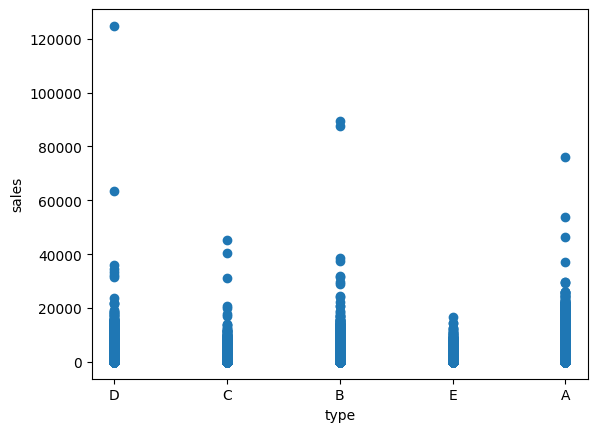

In [ ]:
# это же, виуально
plt.scatter(train_df['type'], train_df['sales'])

plt.ylabel('sales')
plt.xlabel('type')

plt.show()

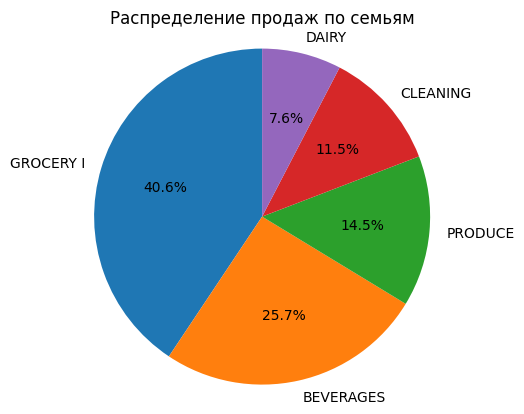

In [ ]:
# Сгруппируем данные по семействам и рассчитайте общий объем продаж для каждой семьи
family_sales = train_df.groupby('family')['sales'].sum()
# Отсортируем семейства по объему продаж в порядке убывания
family_sales_sorted = family_sales.sort_values(ascending=False)
# Получим топ-5 семей с самыми высокими продажами
top_families = family_sales_sorted.head(5)
# Построим pie-график
plt.pie(top_families, labels=top_families.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение продаж по семьям')
plt.axis('equal')
plt.show()

Судя по приведенной выше круговой диаграмме, в продуктовом магазине I самые высокие продажи, а напитки занимают второе место.

Способна ли реклама товара улучшить продажи?

Используем корреляционный тест Пирсона, чтобы определить взаимосвязь между двумя переменными, поскольку обе переменные являются числовыми. Коэффициент корреляции Пирсона измеряет линейную зависимость между двумя непрерывными переменными и находится в диапазоне от -1 до +1.

H0 (>0,05)= Акция не влияет на продажи в магазине.

H1 (<0,05)= Акция действительно влияет на продажи в магазине.

In [ ]:
correlation, p_value = pearsonr(train_df['onpromotion'], train_df['sales'])

print("Корреляция пирсона:", correlation)
print("p-value:", p_value)

Корреляция пирсона: 0.42792320481230584
p-value: 0.0


Основываясь на коэффициенте корреляции Пирсона, равном 0,4279, и значении p, равном 0,0, мы можем отклонить нулевую гипотезу (H0) и заключить, что существует существенная взаимосвязь между рекламой и продажами в магазине. Таким образом, акция действительно влияет на продажи в магазине.

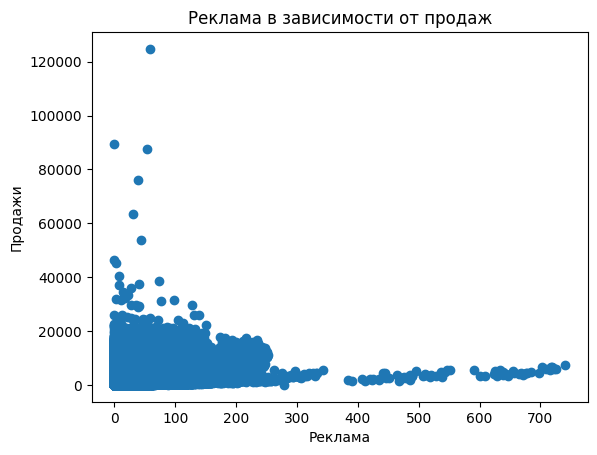

In [ ]:
plt.scatter(train_df['onpromotion'], train_df['sales'])

plt.xlabel('Реклама')
plt.ylabel('Продажи')
plt.title('Реклама в зависимости от продаж')

plt.show()

В каком городе больше всего клиентов?

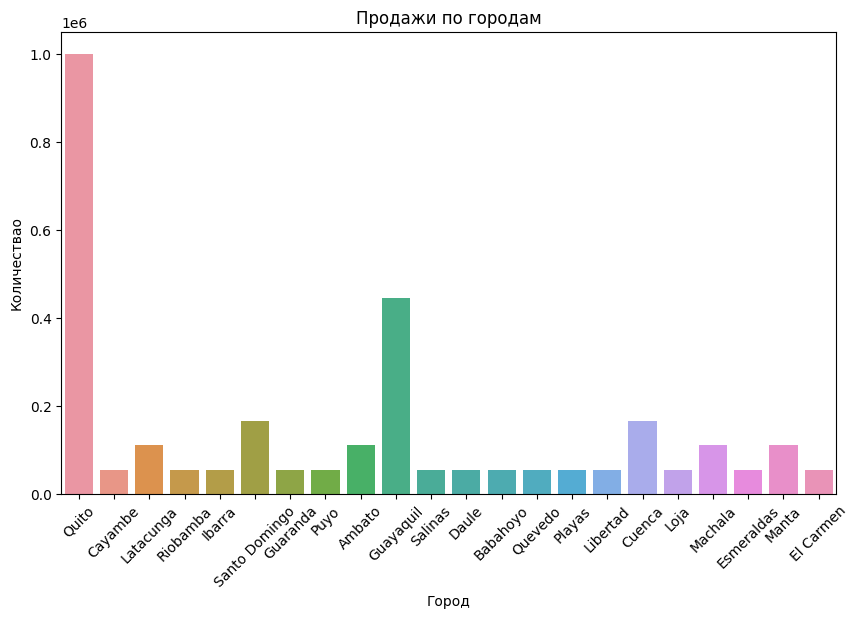

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='city')

plt.xlabel('Город')
plt.ylabel('Количествао')
plt.title('Продажи по городам')

plt.xticks(rotation=45)

plt.show()


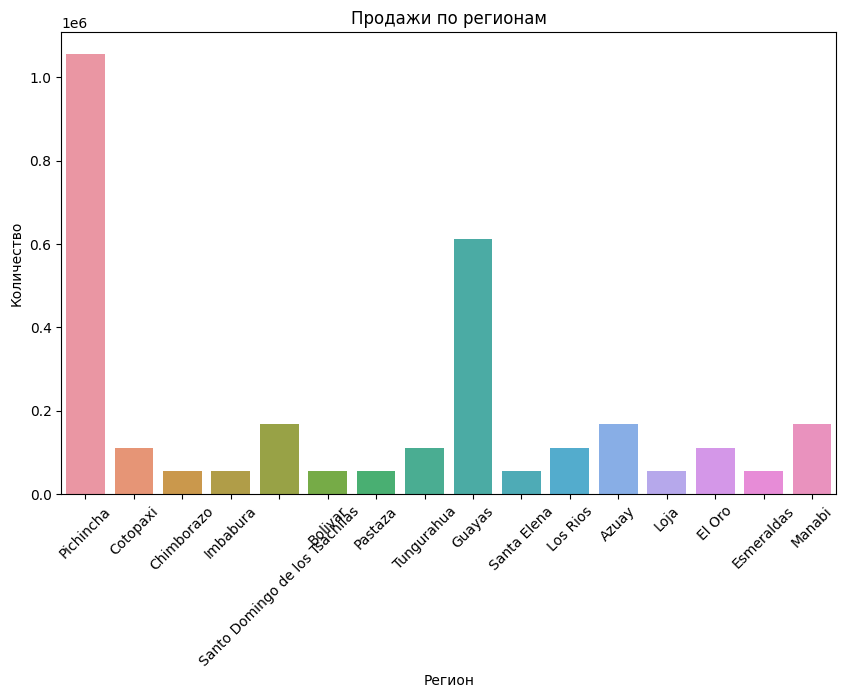

In [ ]:
# По регионам
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='state')

plt.xlabel('Регион')
plt.ylabel('Количество')
plt.title('Продажи по регионам')

plt.xticks(rotation=45)

plt.show()

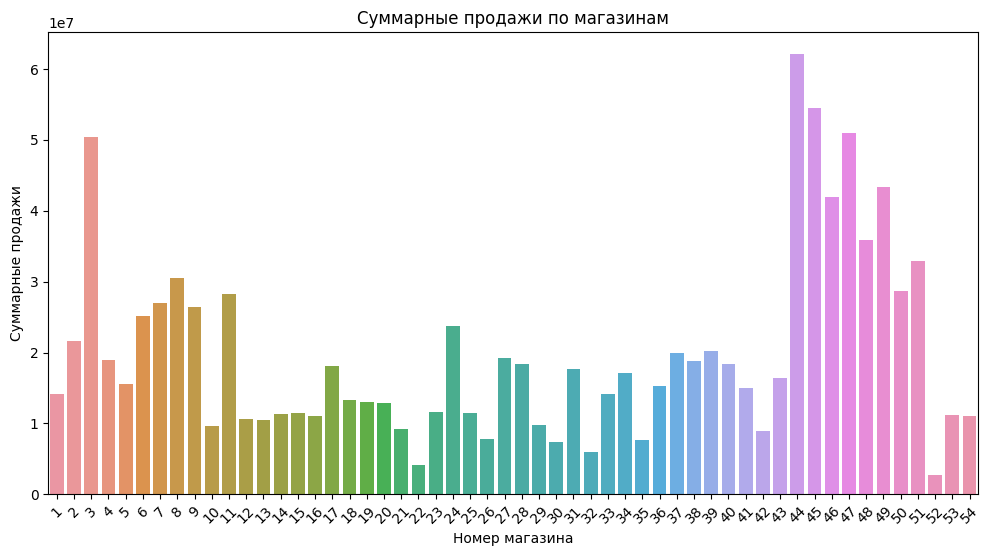

In [ ]:
# Рассчитаем общий объем продаж для каждого магазина
store_sales = train_df.groupby('store_nbr')['sales'].sum().reset_index()

# Отсортируем магазины по объему продаж в порядке убывания
store_sales = store_sales.sort_values('sales', ascending=False)

# bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=store_sales, x='store_nbr', y='sales')

plt.xlabel('Номер магазина')
plt.ylabel('Суммарные продажи')
plt.title('Суммарные продажи по магазинам')

plt.xticks(rotation=45)

plt.show()

In [ ]:
train_df['date']= pd.to_datetime(train_df['date'])

train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year

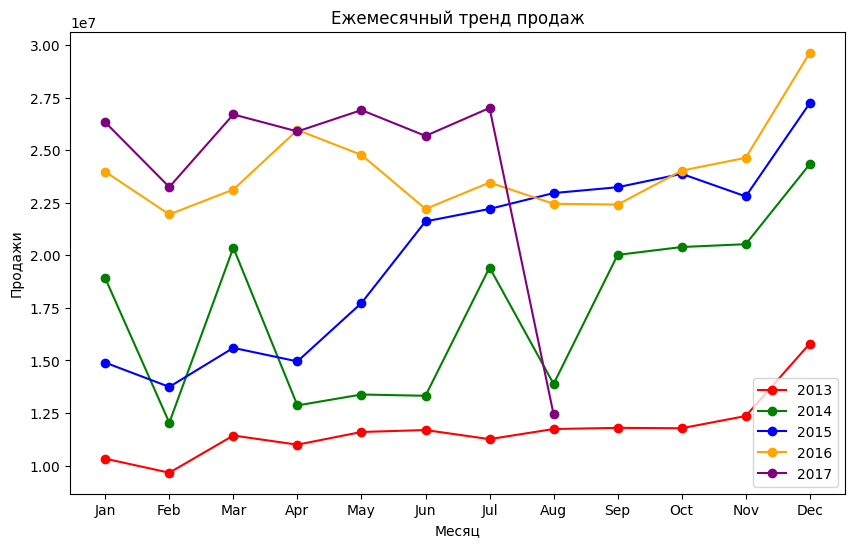

In [ ]:
# Сгруппируем данные по месяцам, годам и рассчитайте общий объем продаж
monthly_sales = train_df.groupby(['month', 'year'])['sales'].sum().reset_index()

plt.figure(figsize=(10, 6))

# Пройдемся по всем годам
years = monthly_sales['year'].unique()
colors = itertools.cycle(['red', 'green', 'blue', 'orange', 'purple'])
for year in years:
    year_data = monthly_sales[monthly_sales['year'] == year]
    plt.plot(year_data['month'], year_data['sales'], marker='o', color=next(colors), label=str(year))

plt.xlabel('Месяц')
plt.ylabel('Продажи')
plt.title('Ежемесячный тренд продаж')

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)

plt.legend()
plt.show()

В целом, линейка orange 2016 года имеет стабильно высокие продажи с января по декабрь. Между месяцами 2016 года в декабре было больше всего продаж. С другой стороны, по сравнению с другими годами, в 2013 году были достигнуты в целом самые низкие показатели продаж, особенно в феврале.

In [ ]:
train_df = train_df.groupby('date')['sales','onpromotion'].sum().reset_index()
print(train_df)

           date      sales  onpromotion
0    2013-01-01    2511.62            0
1    2013-01-02  496092.42            0
2    2013-01-03  361461.23            0
3    2013-01-04  354459.68            0
4    2013-01-05  477350.12            0
...         ...        ...          ...
1679 2017-08-11  826373.72        14179
1680 2017-08-12  792630.54         8312
1681 2017-08-13  865639.68         9283
1682 2017-08-14  760922.41         8043
1683 2017-08-15  762661.94        10605

[1684 rows x 3 columns]


<ipython-input-102-83a8cbf51b54>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_df = train_df.groupby('date')['sales','onpromotion'].sum().reset_index()


### Автокорреляция

Автокорреляция измеряет корреляцию между временным рядом и его запаздывающими значениями. Графики автокорреляции (ACF) и частичной автокорреляции (PACF) помогают идентифицировать значительные значения запаздывания и потенциальные компоненты авторегрессии или скользящего среднего.

- Если значение автокорреляции близко к 1 или -1, это указывает на сильную положительную или отрицательную автокорреляцию соответственно.

- Если значение автокорреляции близко к 0, это указывает на слабую автокорреляцию или ее отсутствие.

In [ ]:
sales_series = train_df['sales']
autocorr_values = sales_series.autocorr()
print("Autocorrelation:", autocorr_values)

Autocorrelation: 0.7668836879523089


Основываясь на приведенном выше результате, поскольку значение автокорреляции близко к 1 (0,766), это говорит о наличии положительной автокорреляции. Положительная автокорреляция указывает на наличие взаимосвязи между текущими значениями продаж и предыдущими значениями продаж.

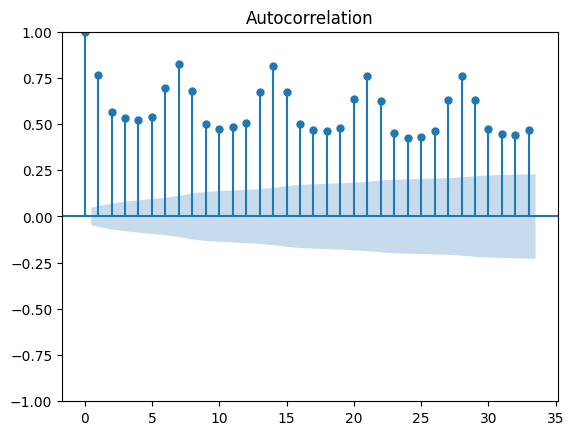

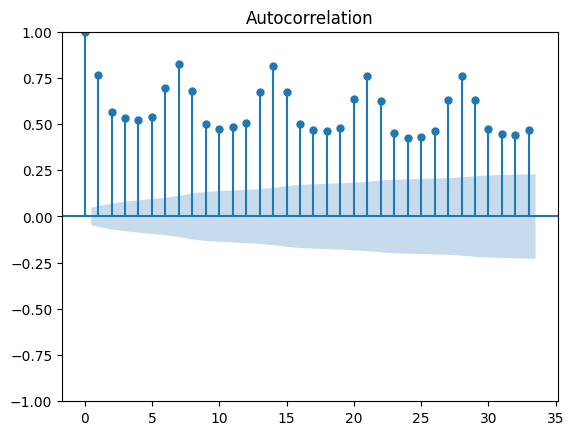

In [ ]:
plot_acf(train_df['sales'])

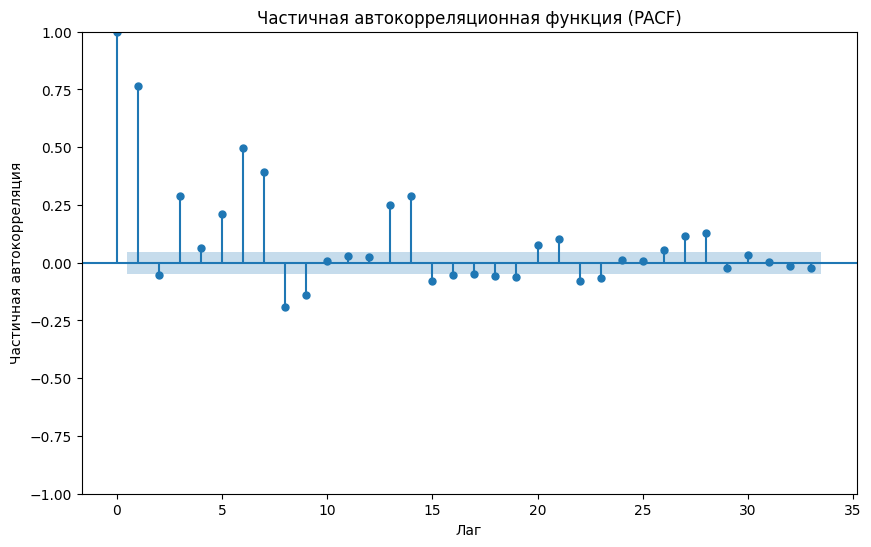

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(train_df['sales'], ax=ax)
plt.xlabel('Лаг')
plt.ylabel('Частичная автокорреляция')
plt.title('Частичная автокорреляционная функция (PACF)')

plt.show()

# Дифференцирование ВР

Этот процесс предназначен для преобразования данных временных рядов в стационарные, поскольку модель ARIMA работает только со стационарными данными временных рядов.

In [ ]:
train_df['diff_sales'] = train_df['sales'].diff()

In [ ]:
train_df = train_df.dropna()

In [ ]:
print(train_df['diff_sales'])

1       493580.80
2      -134631.19
3        -7001.55
4       122890.44
5        42345.28
          ...    
1679    174986.81
1680    -33743.19
1681     73009.14
1682   -104717.27
1683      1739.53
Name: diff_sales, Length: 1683, dtype: float64


<Axes: >

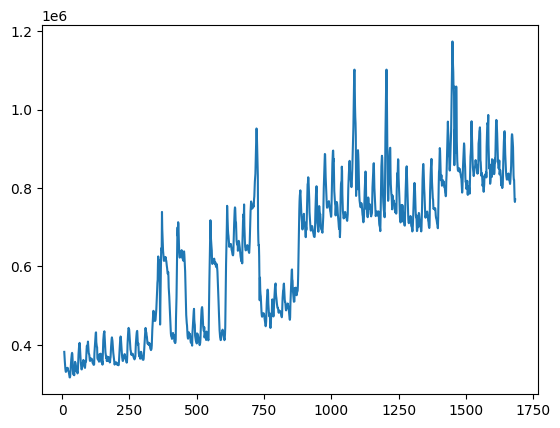

In [ ]:
train_df['sales'].rolling(7).mean().plot()

<Axes: >

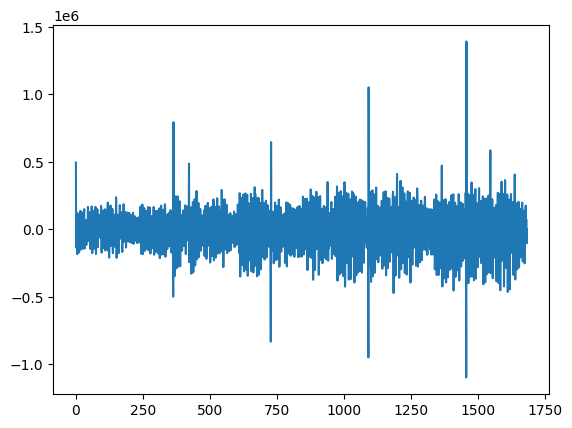

In [ ]:
train_df['diff_sales'].plot()

<Axes: >

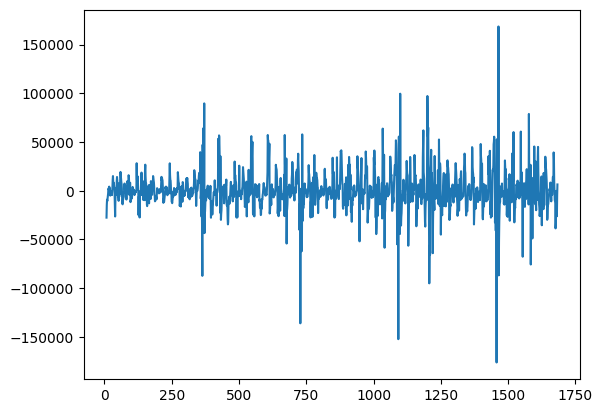

In [ ]:
train_df['diff_sales'].rolling(7).mean().plot()

In [ ]:
train_df['diff_sales'] = train_df['sales'] - train_df['sales'].shift(1)

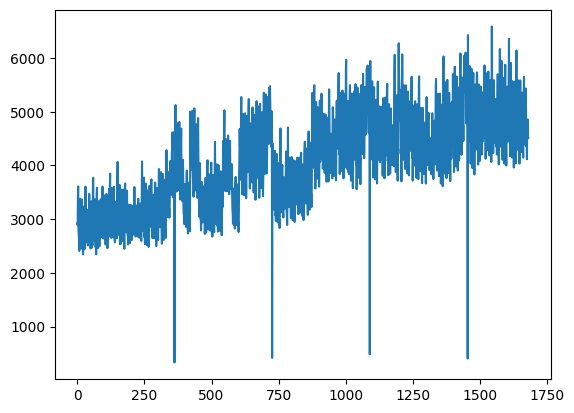

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

log_plot, boxcox_coeff = boxcox(train_df['sales'])

plt.plot(log_plot)

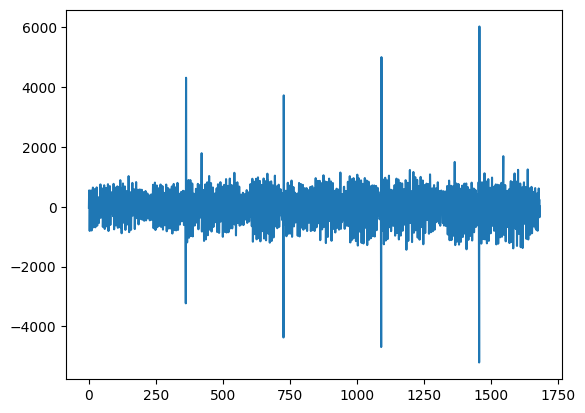

In [ ]:
diff_log = pd.Series(log_plot) - pd.Series(log_plot).shift(1)

plt.plot(diff_log)

<Axes: >

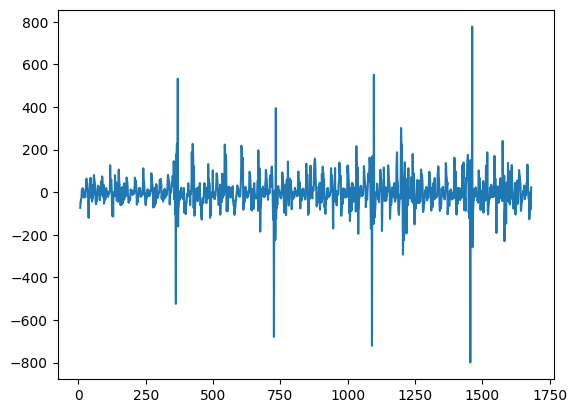

In [ ]:
pd.Series(diff_log).rolling(7).mean().plot()

<ipython-input-144-0aba8b72a87c>:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(autocorrelation)), autocorrelation, use_line_collection=True)
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


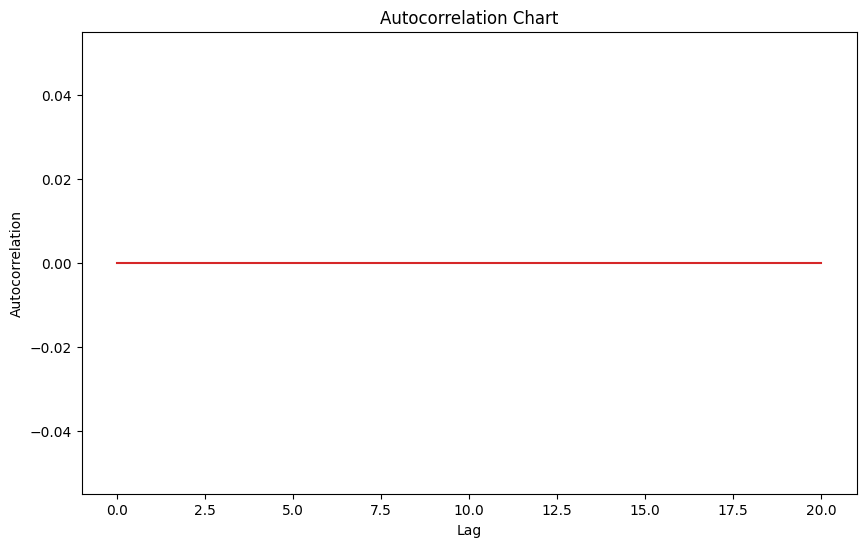

In [ ]:
autocorrelation = sm.tsa.acf(diff_log, nlags=20)

# Построим диаграмму автокорреляции
plt.figure(figsize=(10, 6))
plt.stem(range(len(autocorrelation)), autocorrelation, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Chart')
plt.show()

In [ ]:
train_df.index = train_df.date


In [ ]:
train_df_frq = train_df.asfreq('D').dropna()
len(train_df_frq)

1686

In [ ]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [ ]:
train_df_agg = train_df.groupby('date').agg({'sales': 'mean'}).reset_index()
train_df_agg.date = pd.to_datetime(train_df_agg.date)
train_df_agg

,date,sales
0,2013-01-01,1.41
1,2013-01-02,278.39
2,2013-01-03,202.84
3,2013-01-04,198.91
4,2013-01-05,267.87
...,...,...
1679,2017-08-11,463.73
1680,2017-08-12,444.80
1681,2017-08-13,485.77
1682,2017-08-14,427.00


In [ ]:
train_df_agg.index = train_df_agg.date

In [ ]:
train_df_agg = train_df_agg.to_period('D')
train_df_agg

,date,sales
date,,
2013-01-01,2013-01-01,1.41
2013-01-02,2013-01-02,278.39
2013-01-03,2013-01-03,202.84
2013-01-04,2013-01-04,198.91
2013-01-05,2013-01-05,267.87
...,...,...
2017-08-11,2017-08-11,463.73
2017-08-12,2017-08-12,444.80
2017-08-13,2017-08-13,485.77


In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier

fr = CalendarFourier(freq='A', order = 15)

from statsmodels.tsa.deterministic import DeterministicProcess

d = DeterministicProcess(
    index = train_df_agg.index,
    constant=True,
    order =2,
    seasonal=True,
    # fourier=10,
    additional_terms = [fr],
    drop=True
)

In [ ]:
d.in_sample()

,const,trend,trend_squared,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)",...,"sin(11,freq=A-DEC)","cos(11,freq=A-DEC)","sin(12,freq=A-DEC)","cos(12,freq=A-DEC)","sin(13,freq=A-DEC)","cos(13,freq=A-DEC)","sin(14,freq=A-DEC)","cos(14,freq=A-DEC)","sin(15,freq=A-DEC)","cos(15,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,1.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,1.00e+00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
2013-01-02,1.0,2.0,4.00e+00,1.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.19,9.82e-01,0.21,0.98,0.22,0.98,0.24,0.97,0.26,0.97
2013-01-03,1.0,3.0,9.00e+00,0.0,1.0,0.0,0.0,0.0,0.0,0.03,...,0.37,9.29e-01,0.40,0.92,0.43,0.90,0.46,0.89,0.49,0.87
2013-01-04,1.0,4.0,1.60e+01,0.0,0.0,1.0,0.0,0.0,0.0,0.05,...,0.54,8.43e-01,0.58,0.81,0.62,0.78,0.66,0.75,0.70,0.71
2013-01-05,1.0,5.0,2.50e+01,0.0,0.0,0.0,1.0,0.0,0.0,0.07,...,0.69,7.27e-01,0.74,0.68,0.78,0.63,0.82,0.57,0.86,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,2.82e+06,0.0,0.0,0.0,0.0,0.0,1.0,-0.63,...,-0.93,-3.66e-01,0.95,-0.30,-0.55,0.83,-0.09,-1.00,0.70,0.71
2017-08-12,1.0,1681.0,2.83e+06,0.0,0.0,0.0,0.0,0.0,0.0,-0.64,...,-0.98,-1.84e-01,0.87,-0.49,-0.35,0.94,-0.33,-0.94,0.86,0.51
2017-08-13,1.0,1682.0,2.83e+06,1.0,0.0,0.0,0.0,0.0,0.0,-0.66,...,-1.00,4.30e-03,0.75,-0.66,-0.14,0.99,-0.55,-0.84,0.96,0.28


In [ ]:
d.out_of_sample(steps=200)

,const,trend,trend_squared,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)",...,"sin(11,freq=A-DEC)","cos(11,freq=A-DEC)","sin(12,freq=A-DEC)","cos(12,freq=A-DEC)","sin(13,freq=A-DEC)","cos(13,freq=A-DEC)","sin(14,freq=A-DEC)","cos(14,freq=A-DEC)","sin(15,freq=A-DEC)","cos(15,freq=A-DEC)"
2017-08-16,1.0,1685.0,2.84e+06,0.0,0.0,0.0,1.0,0.0,0.0,-0.69,...,-0.84,0.54,0.23,-0.97,0.51,0.86,-0.96,-0.27,0.88,-0.47
2017-08-17,1.0,1686.0,2.84e+06,0.0,0.0,0.0,0.0,1.0,0.0,-0.71,...,-0.72,0.69,0.03,-1.00,0.69,0.73,-1.00,-0.03,0.73,-0.68
2017-08-18,1.0,1687.0,2.85e+06,0.0,0.0,0.0,0.0,0.0,1.0,-0.72,...,-0.58,0.81,-0.18,-0.98,0.83,0.56,-0.98,0.21,0.53,-0.85
2017-08-19,1.0,1688.0,2.85e+06,0.0,0.0,0.0,0.0,0.0,0.0,-0.73,...,-0.42,0.91,-0.38,-0.93,0.93,0.36,-0.90,0.44,0.30,-0.95
2017-08-20,1.0,1689.0,2.85e+06,1.0,0.0,0.0,0.0,0.0,0.0,-0.74,...,-0.24,0.97,-0.56,-0.83,0.99,0.14,-0.77,0.64,0.04,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-27,1.0,1880.0,3.53e+06,0.0,0.0,1.0,0.0,0.0,0.0,0.83,...,-0.98,-0.20,-0.71,0.70,0.19,0.98,0.92,0.39,0.84,-0.55
2018-02-28,1.0,1881.0,3.54e+06,0.0,0.0,0.0,1.0,0.0,0.0,0.84,...,-1.00,-0.01,-0.55,0.83,0.40,0.92,0.99,0.16,0.67,-0.74
2018-03-01,1.0,1882.0,3.54e+06,0.0,0.0,0.0,0.0,1.0,0.0,0.85,...,-0.98,0.18,-0.37,0.93,0.59,0.80,1.00,-0.08,0.46,-0.89
2018-03-02,1.0,1883.0,3.55e+06,0.0,0.0,0.0,0.0,0.0,1.0,0.86,...,-0.93,0.36,-0.17,0.99,0.76,0.65,0.95,-0.32,0.21,-0.98


In [ ]:
from sklearn.linear_model import LinearRegression


lr = LinearRegression()

lr.fit(d.in_sample(), train_df_agg.sales)

LinearRegression()

In [ ]:
preds = lr.predict(d.out_of_sample(steps=200))

In [ ]:
pd.DataFrame(index= d.out_of_sample(steps=200).index, data=preds, columns=['sales'])

,sales
2017-08-16,468.66
2017-08-17,437.05
2017-08-18,414.14
2017-08-19,427.84
2017-08-20,464.04
...,...
2018-02-27,551.06
2018-02-28,549.82
2018-03-01,524.26
2018-03-02,505.66


<Axes: xlabel='date'>

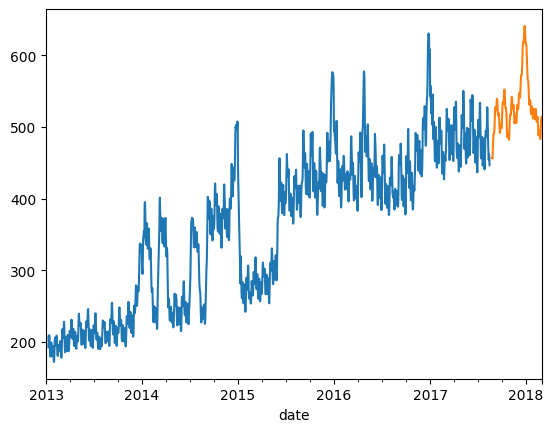

In [ ]:
train_df_agg.sales.rolling(10).mean().plot()
pd.DataFrame(index= d.out_of_sample(steps=200).index, data=preds, columns=['sales']).sales.rolling(10).mean().plot()

In [ ]:
train_df_frq.dropna()

,date,sales,onpromotion,diff_sales
date,,,,
2013-01-03,2013-01-03,361461.23,0.0,-134631.19
2013-01-04,2013-01-04,354459.68,0.0,-7001.55
2013-01-05,2013-01-05,477350.12,0.0,122890.44
2013-01-06,2013-01-06,519695.40,0.0,42345.28
2013-01-07,2013-01-07,336122.80,0.0,-183572.60
...,...,...,...,...
2017-08-11,2017-08-11,826373.72,14179.0,174986.81
2017-08-12,2017-08-12,792630.54,8312.0,-33743.19
2017-08-13,2017-08-13,865639.68,9283.0,73009.14


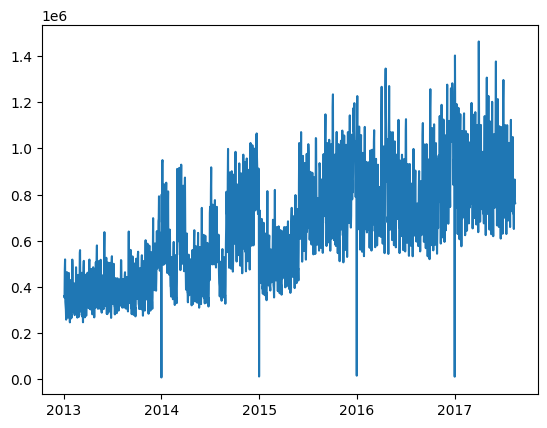

In [ ]:
plt.plot(train_df['sales'])

In [ ]:
train_df = train_df.dropna()

<ipython-input-112-7629ed19dc94>:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(autocorrelation)), autocorrelation, use_line_collection=True)


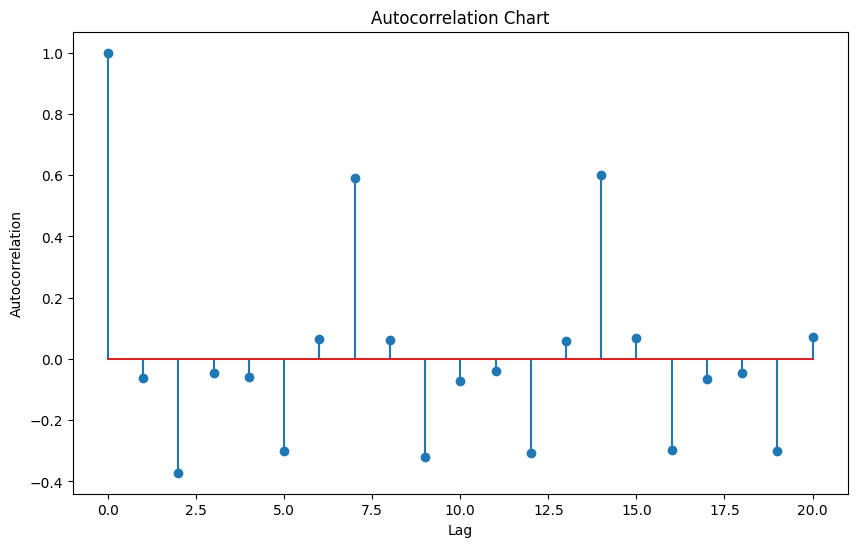

In [ ]:
autocorrelation = sm.tsa.acf(train_df['diff_sales'], nlags=20)

# Построим диаграмму автокорреляции
plt.figure(figsize=(10, 6))
plt.stem(range(len(autocorrelation)), autocorrelation, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Chart')
plt.show()

# Тест на стационарность


Существуют различные статистические тесты для проверки стационарности, включая расширенный тест Дики-Фуллера (ADF) и тест Квятковского-Филлипса-Шмидта-Шина (KPSS).

### Расширенный тест Дики-Фуллера (ADF)

Расширенный тест Дики-Фуллера (ADF) - это статистический тест, используемый для определения того, является ли временной ряд стационарным или нестационарным. Стационарность является важным допущением во многих моделях анализа временных рядов.

Тест ADF оценивает нулевую гипотезу о том, что временной ряд имеет единичный корень, что указывает на нестационарность. Альтернативная гипотеза заключается в том, что временной ряд является стационарным.

* При выполнении теста ADF мы получаем статистику ADF и p-значение.
* Статистика ADF - это отрицательное число, и чем оно отрицательнее, тем сильнее доказательства против нулевой гипотезы.
* Значение p представляет вероятность наблюдения статистики ADF или более экстремального значения, если бы нулевая гипотеза была верна.
* Низкое значение p (ниже выбранного уровня значимости, обычно 0,05) указывает на убедительные доказательства против нулевой гипотезы и предполагает, что временной ряд является стационарным.

In [ ]:
ts = train_df['diff_sales']

In [ ]:
result = adfuller(ts)

# Извлекаем и отображаем статистику теста и p-значение
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -11.494679187188892
p-value: 4.6451710540996276e-21


Статистика ADF составляет -11,49. Эта статистика принимает отрицательное значение и меньше, чем критические значения на общих уровнях значимости. Это дает веские доказательства против нулевой гипотезы о единичном корне, указывающие на то, что временной ряд является стационарным.

Значение p равно 4,64e-21, что является очень малым значением, близким к нулю. Как правило, если значение p ниже выбранного уровня значимости (например, 0,05), это указывает на веские доказательства для отклонения нулевой гипотезы. В вашем случае чрезвычайно малое значение p свидетельствует о веских доказательствах против наличия единичного корня и подтверждает стационарность временных рядов.

### Квятковски-Филлипс-Шмидт-Шин (KPSS)

Тест Квятковского-Филлипса-Шмидта-Шина (KPSS) - это еще один статистический тест, используемый для оценки стационарности временного ряда. Он дополняет расширенный тест Дики-Фуллера (ADF).

Тест KPSS оценивает нулевую гипотезу о том, что временной ряд является стационарным, в сравнении с альтернативной гипотезой о нестационарности. В отличие от теста ADF, который предполагает наличие единичного корня, тест KPSS предполагает отсутствие единичного корня.

Тест вычисляет статистику KPSS, которая измеряет совокупную сумму квадратов отклонений от среднего значения в ряду. Он также предоставляет значение p, которое указывает на вероятность наблюдения статистики KPSS или более экстремального значения при нулевой гипотезе.

Интерпретация результатов теста KPSS включает в себя рассмотрение статистики KPSS и связанного с ней p-значения. Если статистика KPSS превышает критическое значение при выбранном уровне значимости (например, 0,05), это свидетельствует против нулевой гипотезы стационарности. И наоборот, если статистика KPSS меньше критического значения, это говорит о том, что временной ряд является стационарным.

In [ ]:
result = kpss(ts)

kpss_statistic = result[0]
p_value = result[1]
print("KPSS Statistic:", kpss_statistic)
print("p-value:", p_value)

KPSS Statistic: 0.026854877460035127
p-value: 0.1


<ipython-input-117-ebc0418c7364>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(ts)


Статистический показатель KPSS составляет 0,026. Эта статистика измеряет расхождение между наблюдаемым рядом и тенденцией ряда. Это указывает на то, насколько сильно ряд отклоняется от стационарности. Меньшая статистика KPSS предполагает более близкое соответствие стационарности.

Значение p равно 0,1, что равно выбранному уровню значимости 0,1. Как правило, если значение p больше уровня значимости, это говорит о том, что нет достаточных доказательств для отклонения нулевой гипотезы стационарности. Исходя из результата, значение p равно уровню значимости, что указывает на то, что результаты являются неубедительными.

### ACF & PACF

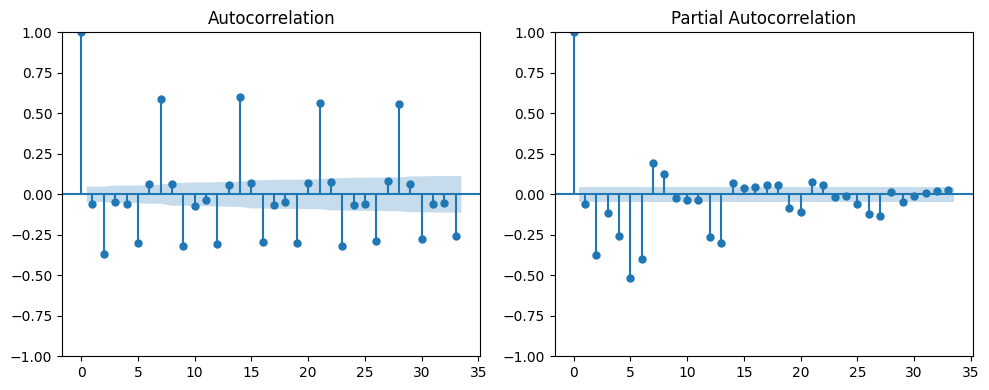

In [ ]:
# Построить функцию автокорреляции (ACF)
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plot_acf(train_df['diff_sales'], ax=ax1)

# Построим график частичной автокорреляционной функции (PACF)
ax2 = plt.subplot(122)
plot_pacf(train_df['diff_sales'], ax=ax2)

plt.tight_layout()
plt.show()

# Модель интегрированной авторегрессионной скользящей средней (ARIMA)

In [ ]:
p = 2
d = 1
q = 1

train_np = train_df['diff_sales'].values.astype('float64')
model = sm.tsa.ARIMA(train_np, order=(p, d, q))

result = model.fit()

In [ ]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1682
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -22466.312
Date:                Sat, 21 Oct 2023   AIC                          44940.623
Time:                        10:19:49   BIC                          44962.332
Sample:                             0   HQIC                         44948.664
                               - 1682                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0844      0.024     -3.459      0.001      -0.132      -0.037
ar.L2         -0.3759      0.027    -14.179      0.000      -0.428      -0.324
ma.L1         -0.9992      0.036    -27.920      0.0

In [ ]:
# Прогнозируем
start_idx = len(train_np)
end_idx = len(train_np) + len(test_df) - 1
predictions = result.predict(start=start_idx, end=end_idx)

print(predictions)

[ 39458.28697651  -3743.29116372 -14277.55293312 ...    164.19246274
    164.19246274    164.19246274]


In [ ]:
actual_values = train_df['diff_sales']

In [ ]:
# Дополним массив прогнозов, чтобы он соответствовал длине actual_values
predictions = predictions[:len(actual_values)]

# Расчет показателей оценки
mae = np.mean(np.abs(predictions - actual_values))
mse = np.mean((predictions - actual_values) ** 2)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 116113.50315596268
Mean Squared Error (MSE): 25441765312.49467
Root Mean Squared Error (RMSE): 159504.7501251755


In [ ]:
train_df

,date,sales,onpromotion,diff_sales
date,,,,
2013-01-03,2013-01-03,361461.23,0,-134631.19
2013-01-04,2013-01-04,354459.68,0,-7001.55
2013-01-05,2013-01-05,477350.12,0,122890.44
2013-01-06,2013-01-06,519695.40,0,42345.28
2013-01-07,2013-01-07,336122.80,0,-183572.60
...,...,...,...,...
2017-08-11,2017-08-11,826373.72,14179,174986.81
2017-08-12,2017-08-12,792630.54,8312,-33743.19
2017-08-13,2017-08-13,865639.68,9283,73009.14


In [ ]:
p = 2
d = 2
q = 2

train_np = train_df['diff_sales'].values.astype('float64')
model = sm.tsa.SARIMAX(train_np, trend ='t', order=(p,d,q), seasonal_order=(1, d, q, 30))

result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


KeyboardInterrupt: ignored

In [ ]:
# Дополним массив прогнозов, чтобы он соответствовал длине actual_values
predictions = predictions[:len(actual_values)]

# Расчет показателей оценки
mae = np.mean(np.abs(predictions - actual_values))
mse = np.mean((predictions - actual_values) ** 2)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 116113.50315596268
Mean Squared Error (MSE): 25441765312.49467
Root Mean Squared Error (RMSE): 159504.7501251755
